In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (18,12)

In [3]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [4]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [5]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [6]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd


,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [7]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier


primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [8]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [9]:
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [10]:
#Dados completo.
data = trainingd.iloc[:,:].values
#treino (70%)
train = trainingd.iloc[0:174,:].values  
#teste (30%)
test = trainingd.iloc[174:,:].values 

print('Completo:',len(data))
print('treino:',len(train))
print('teste:',len(test))
data.shape

Completo: 248
treino: 174
teste: 74


(248, 1)

In [11]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.fit_transform(test)


In [12]:
#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def prepara_test_x(trainingd,lags,test):
    entradas = trainingd[len(trainingd) - len(test) - lags:].values
    entradas = entradas.reshape(-1, 1)
    entradas = sc.fit_transform(entradas)

    test_X = []
    for i in range(lags, lags+len(test)):
        test_X.append(entradas[i-lags:i, 0])
    test_X = np.array(test_X)
    return test_X
    

def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

In [13]:
#LSTM
lags_lstm = 43 # Equivalente à 25% dos dados de treino.
#Prepara os dados de treinamento
train_X, train_y = prepara_dados(train, lags_lstm)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

#Prepara os dados de teste
#entradas = trainingd[len(trainingd) - len(test) - lags:].values
#entradas = entradas.reshape(-1, 1)
#entradas = sc.fit_transform(entradas)

#test_X = []
#for i in range(lags, lags+len(test)):
 #   test_X.append(entradas[i-lags:i, 0])
#test_X = np.array(test_X)

#Prepara os dados do teste
test_X = prepara_test_x(trainingd,lags_lstm,test)

test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

#Cria o modelo

model_lstm = Sequential()
model_lstm.add(LSTM(units = 10, input_shape = (train_X.shape[1], 1)))
model_lstm.add(Dense(10, activation = 'linear'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation = 'linear'))
model_lstm.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

#Treina o modelo
model_lstm.fit(train_X, train_y, batch_size = 32, epochs = 100)
#score = model.score(train_X,train_y)
#print(score)

#Dados de teste
previsoes_lstm = model_lstm.predict(test_X)
previsoes_lstm = previsoes_lstm.reshape(-1,1)
previsoes_lstm = sc.inverse_transform(previsoes_lstm)

#Dados de treino
previsoes_treino_lstm = model_lstm.predict(train_X)
previsoes_treino_lstm = previsoes_treino_lstm.reshape(-1,1)
previsoes_treino_lstm = sc.inverse_transform(previsoes_treino_lstm)


Train on 131 samples
Epoch 1/100
131/131 [==============================] - 2s 12ms/sample - loss: 0.4877 - mean_absolute_error: 0.4877
Epoch 2/100
131/131 [==============================] - 0s 1ms/sample - loss: 0.4181 - mean_absolute_error: 0.4181
Epoch 3/100
131/131 [==============================] - 0s 1ms/sample - loss: 0.3308 - mean_absolute_error: 0.3308
Epoch 4/100
131/131 [==============================] - 0s 1ms/sample - loss: 0.2603 - mean_absolute_error: 0.2603
Epoch 5/100
131/131 [==============================] - 0s 1ms/sample - loss: 0.2016 - mean_absolute_error: 0.2016
Epoch 6/100
131/131 [==============================] - 0s 986us/sample - loss: 0.1636 - mean_absolute_error: 0.1636
Epoch 7/100
131/131 [==============================] - 0s 1ms/sample - loss: 0.1745 - mean_absolute_error: 0.1745
Epoch 8/100
131/131 [==============================] - 0s 1ms/sample - loss: 0.1717 - mean_absolute_error: 0.1717
Epoch 9/100
131/131 [==============================] - 0s 1ms/sa

131/131 [==============================] - 0s 989us/sample - loss: 0.1460 - mean_absolute_error: 0.1460
Epoch 72/100
131/131 [==============================] - 0s 892us/sample - loss: 0.1390 - mean_absolute_error: 0.1390
Epoch 73/100
131/131 [==============================] - 0s 814us/sample - loss: 0.1373 - mean_absolute_error: 0.1373
Epoch 74/100
131/131 [==============================] - 0s 863us/sample - loss: 0.1345 - mean_absolute_error: 0.1345
Epoch 75/100
131/131 [==============================] - 0s 766us/sample - loss: 0.1371 - mean_absolute_error: 0.1371
Epoch 76/100
131/131 [==============================] - 0s 837us/sample - loss: 0.1367 - mean_absolute_error: 0.1367
Epoch 77/100
131/131 [==============================] - 0s 775us/sample - loss: 0.1439 - mean_absolute_error: 0.1439
Epoch 78/100
131/131 [==============================] - 0s 918us/sample - loss: 0.1467 - mean_absolute_error: 0.1467
Epoch 79/100
131/131 [==============================] - 0s 756us/sample - los

In [17]:
#mlp
lags_mlp = 17 # Equivalente à 10% dos dados de treino.
#Prepara os dados de treinamento
train_X, train_y = prepara_dados(train, lags_mlp)
    
#Prepara os dados de teste
test_X = prepara_test_x(trainingd,lags_mlp,test)
    
#Cria o modelo

model_mlp = Sequential()
model_mlp.add(Dense(units = 10, activation = 'relu', input_dim = lags_mlp))
model_mlp.add(Dense(units = 21, activation = 'relu'))
model_mlp.add(Dense(units = 1, activation = 'linear'))
model_mlp.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

#Treina o modelo
model_mlp.fit(train_X, train_y, batch_size = 32, epochs = 100)
#score = model.score(train_X,train_y)
#print(score)

#Dados de teste
previsoes_mlp = model_mlp.predict(test_X)
previsoes_mlp = previsoes_mlp.reshape(-1, 1)
previsoes_mlp = sc.inverse_transform(previsoes_mlp)

#Dados de treino
previsoes_treino_mlp = model_mlp.predict(train_X)
previsoes_treino_mlp = previsoes_treino_mlp.reshape(-1, 1)
previsoes_treino_mlp = sc.inverse_transform(previsoes_treino_mlp)


Train on 157 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/sample - loss: 0.3635 - mean_absolute_error: 0.3635
Epoch 2/100
157/157 [==============================] - 0s 80us/sample - loss: 0.2717 - mean_absolute_error: 0.2717
Epoch 3/100
157/157 [==============================] - 0s 92us/sample - loss: 0.1943 - mean_absolute_error: 0.1943
Epoch 4/100
157/157 [==============================] - 0s 85us/sample - loss: 0.1611 - mean_absolute_error: 0.1611
Epoch 5/100
157/157 [==============================] - 0s 90us/sample - loss: 0.1535 - mean_absolute_error: 0.1535
Epoch 6/100
157/157 [==============================] - 0s 95us/sample - loss: 0.1579 - mean_absolute_error: 0.1579
Epoch 7/100
157/157 [==============================] - 0s 97us/sample - loss: 0.1538 - mean_absolute_error: 0.1538
Epoch 8/100
157/157 [==============================] - 0s 83us/sample - loss: 0.1474 - mean_absolute_error: 0.1474
Epoch 9/100
157/157 [==============================] - 0s 85

157/157 [==============================] - 0s 99us/sample - loss: 0.1141 - mean_absolute_error: 0.1141
Epoch 71/100
157/157 [==============================] - ETA: 0s - loss: 0.1276 - mean_absolute_error: 0.127 - 0s 64us/sample - loss: 0.1127 - mean_absolute_error: 0.1127
Epoch 72/100
157/157 [==============================] - 0s 103us/sample - loss: 0.1131 - mean_absolute_error: 0.1131
Epoch 73/100
157/157 [==============================] - 0s 80us/sample - loss: 0.1123 - mean_absolute_error: 0.1123
Epoch 74/100
157/157 [==============================] - 0s 89us/sample - loss: 0.1117 - mean_absolute_error: 0.1117
Epoch 75/100
157/157 [==============================] - 0s 103us/sample - loss: 0.1121 - mean_absolute_error: 0.1121
Epoch 76/100
157/157 [==============================] - 0s 87us/sample - loss: 0.1111 - mean_absolute_error: 0.1111
Epoch 77/100
157/157 [==============================] - ETA: 0s - loss: 0.1091 - mean_absolute_error: 0.109 - 0s 92us/sample - loss: 0.1111 - mea

In [24]:
#Regressão Linear
lags_rl = 17 # Equivalente à 10% dos dados de treino.
#Prepara os dados de treinamento
train_X, train_y = prepara_dados(train, lags_rl)
    
#Prepara os dados de teste
test_X = prepara_test_x(trainingd,lags_rl,test)
        
#Cria o modelo
model_rl = LinearRegression(normalize=True)

#Treina o modelo
model_rl.fit(train_X,train_y)

#Dados de teste
previsoes_rl = model_rl.predict(test_X)
previsoes_rl = previsoes_rl.reshape(-1, 1)
previsoes_rl = sc.inverse_transform(previsoes_rl)

#Dados de treino
previsoes_treino_rl = model_rl.predict(train_X)
previsoes_treino_rl = previsoes_treino_rl.reshape(-1, 1)
previsoes_treino_rl = sc.inverse_transform(previsoes_treino_rl)

#Preparação para plotagem
train_predict_plot_rl = np.empty_like(data)
train_predict_plot_rl[:, :] = np.nan
train_predict_plot_rl[lags_rl: len(previsoes_treino_rl) + lags_rl, :] = previsoes_treino_rl
train_predict_plot_rl.shape
    
test_predict_plot_rl = np.empty_like(data)
test_predict_plot_rl[:, :] = np.nan
test_predict_plot_rl[len(previsoes_treino_rl)+lags_rl:len(data), :] = previsoes_rl


In [25]:
#Preparação para plotagem lstm

train_predict_plot_lstm = np.empty_like(data)
train_predict_plot_lstm[:, :] = np.nan
train_predict_plot_lstm[lags_lstm: len(previsoes_treino_lstm) + lags_lstm, :] = previsoes_treino_lstm
train_predict_plot_lstm.shape
    
test_predict_plot_lstm = np.empty_like(data)
test_predict_plot_lstm[:, :] = np.nan
test_predict_plot_lstm[len(previsoes_treino_lstm)+lags_lstm:len(data), :] = previsoes_lstm

#Preparação para plotagem mlp

train_predict_plot_mlp = np.empty_like(data)
train_predict_plot_mlp[:, :] = np.nan
train_predict_plot_mlp[lags_mlp: len(previsoes_treino_mlp) + lags_mlp, :] = previsoes_treino_mlp
train_predict_plot_mlp.shape
    
test_predict_plot_mlp = np.empty_like(data)
test_predict_plot_mlp[:, :] = np.nan
test_predict_plot_mlp[len(previsoes_treino_mlp)+lags_mlp:len(data), :] = previsoes_mlp

#Preparação para plotagem rl

train_predict_plot_rl = np.empty_like(data)
train_predict_plot_rl[:, :] = np.nan
train_predict_plot_rl[lags_rl: len(previsoes_treino_rl) + lags_rl, :] = previsoes_treino_rl
train_predict_plot_rl.shape
    
test_predict_plot_rl = np.empty_like(data)
test_predict_plot_rl[:, :] = np.nan
test_predict_plot_rl[len(previsoes_treino_rl)+lags_rl:len(data), :] = previsoes_rl
    

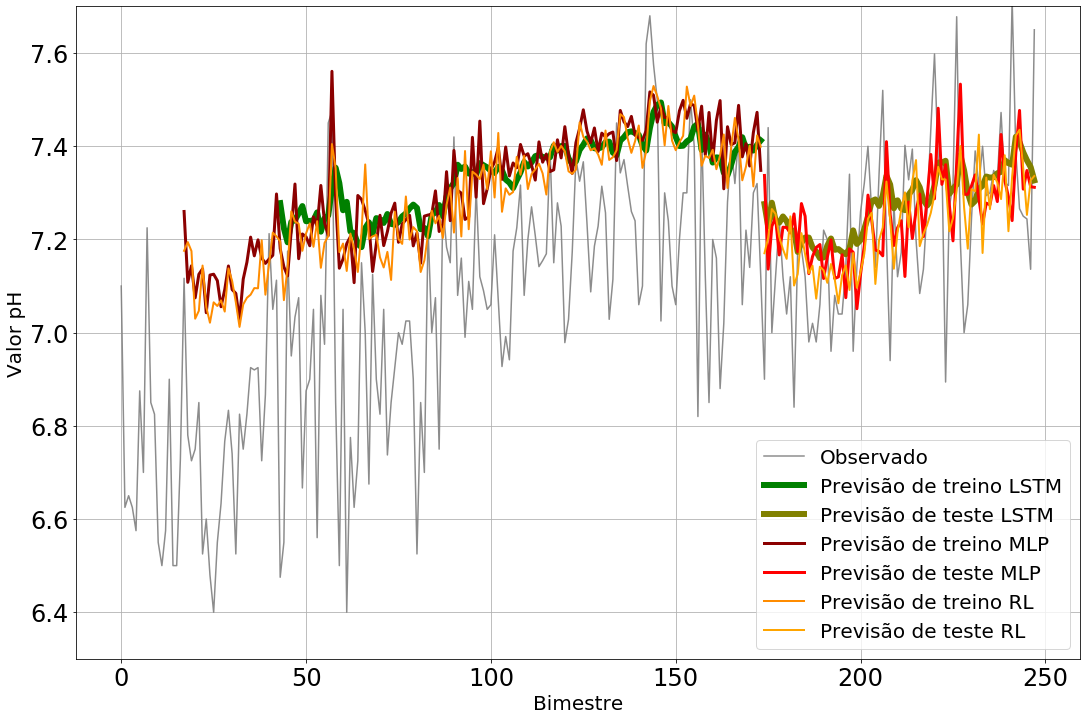

In [71]:
#Plotagem do gráfico #006699
plt.plot(data, color = 'gray',alpha=0.9, label = 'Observado')
plt.plot(train_predict_plot_lstm, color = 'green', label = 'Previsão de treino LSTM',linewidth=6)
plt.plot(test_predict_plot_lstm, color = 'olive', label = 'Previsão de teste LSTM',linewidth=6)
plt.plot(train_predict_plot_mlp, color = 'darkred', label = 'Previsão de treino MLP',linewidth=3)
plt.plot(test_predict_plot_mlp, color = 'r', label = 'Previsão de teste MLP',linewidth=3)
plt.plot(train_predict_plot_rl, color = 'darkorange', label = 'Previsão de treino RL',linewidth=2)
plt.plot(test_predict_plot_rl, color = 'orange', label = 'Previsão de teste RL',linewidth=2)
plt.xlabel('Bimestre')
plt.ylabel('Valor pH')
plt.ylim(6.3,7.7)
plt.legend()
plt.grid()
plt.show()

(248, 1)

174